# Introduction

Dans ce notebook, nous analysons et testons l'efficacité de notre algorithme de Recuit Simulé (Simulated Annealing) appliqué à l'optimisation des tournées de livraison.

L'objectif est de :
- Évaluer les performances de l'algorithme en termes de qualité des solutions et de temps d'exécution.
- Étudier la complexité algorithmique et spatiale.
- Comparer les résultats obtenus avec d'autres approches (par exemple, algorithme glouton).

Et les contraintes sont : 
- Routes dynamiques ou perturbations : Simuler des changements dynamiques dans les coûts ou la disponibilité des routes pendant la résolution.
- Utilisation de plusieurs véhicules: Il peut y avoir plusieurs sous-tournées plutôt qu'une seule grande.
- Coût ou restriction de passage sur certaines arêtes : Certaines routes peuvent être plus coûteuses ou interdites (par exemple, travaux ou routes bloquées).
- Ratio d'embouteillage moyen : Les données de Bison Futé sont utilisées pour calculer un ratio d'embouteillage moyen en fonction de l'heure.
- Capacités du véhicule : Chaque véhicule a une capacité limite pour transporter des marchandises ou des passagers.

# Préparation des données

Nous utilisons des graphes pondérés pour modéliser le réseau routier. Chaque sommet représente une ville, et chaque arête représente une route avec un coût associé.

Les graphes sont générés ou chargés depuis des fichiers sérialisés. Nous analysons également l'impact de la taille et de la densité des graphes sur la mémoire utilisée.

In [ ]:
# Ajouter le chemin vers le dossier src
import sys
import os
sys.path.append(os.path.abspath("../src"))

# Tous les imports nécessaires
from dotenv import load_dotenv
import random
from graph import Graph

# Charger les variables d'environnement
load_dotenv()

# Récupérer les chemins depuis le fichier .env
geonames_path = os.getenv("GEONAMES_PATH")
shapefile_path = os.getenv("SHAPEFILE_PATH")
output_path = os.getenv("OUTPUT_PATH")
serialized_graph_path = os.getenv("SERIALIZE_GRAPH_PATH")

# Variables utilisées dans le notebook

Voici une description des différentes variables présentes dans ce notebook pour mieux comprendre leur rôle :

- **`geonames_path`** (`str`) : Chemin vers le fichier contenant les données des villes de France. Ce fichier est utilisé pour extraire des informations géographiques ou démographiques nécessaires à la construction du graphe.
    - **Valeur** : `./data/FR/cities_of_france.txt`
  

- **`graph`** (`graph.Graph`) : Objet représentant le graphe chargé. Ce graphe modélise le réseau routier avec des sommets (villes) et des arêtes (routes) associées à des coûts.


- **`graph_path`** (`str`) : Chemin vers le fichier sérialisé contenant un graphe préalablement généré. Ce fichier est chargé pour effectuer les analyses et tests.
    - **Valeur** : `./data/datasets/size_200/graph_size200_density0.01.pkl`
  

- **`shapefile_path`** (`str`) : Chemin vers le fichier shapefile contenant les données géographiques de la France. Ce fichier est utilisé pour enrichir le graphe avec des informations géospatiales.
    - **Valeur** : `./data/FR/ne_10m_admin_0_countries_fra/ne_10m_admin_0_countries_fra.shp`

# Implémentation de l'algorithme

Nous utilisons un algorithme de Recuit Simulé pour résoudre le problème d'optimisation des tournées. Cet algorithme est particulièrement adapté pour explorer efficacement un grand espace de solutions tout en évitant les minima locaux. Voici les étapes principales de l'algorithme :
```plaintext
Début

1. Choisir un noeud de départ aléatoire parmi les noeuds du graphe
2. Retirer ce noeud de la liste des noeuds à visiter

3. INITIALISER une solution :
    - Répartir aléatoirement les noeuds restants entre les véhicules
    - Chaque tournée commence et termine par le noeud de départ

4. Calculer le coût total de la solution initiale
5. Sauvegarder la solution initiale comme meilleure solution trouvée

6. Température ← initial_temp

7. Tant que Température > min_temp :

    a. Appliquer une modification dynamique du graphe (shuffle_graph)

    b. Répéter max_iterations fois :

        i. Générer une solution voisine :
            - Déplacer un noeud d'un véhicule vers un autre

        ii. Calculer le coût de la solution voisine

        iii. Si coût_voisin < coût_courant :
             - Accepter la solution voisine

        iv. Sinon :
             - Accepter avec probabilité exp(-(coût_voisin - coût_courant) / Température)

        v. Si coût_voisin < coût_meilleur :
             - Mettre à jour la meilleure solution

    c. Refroidir la température :
        - Température ← Température × cooling_rate

8. Retourner la meilleure solution trouvée et le temps d'exécution

Fin
```

Changer
![Flowchart](flowchart_simulated_annealing.svg)

# 🧪 Protocole de test de l'algorithme de Recuit Simulé Multi-Véhicules

## 1. Objectif

Évaluer la performance de l'algorithme **Simulated Annealing Multi-Vehicle** en fonction de :

- **Nombre de sommets** (`n`).
- **Densité du graphe** (`d`).
- **Nombre de véhicules** (`k`).

Et mesurer :

- **Temps d'exécution**.
- **Nombre total d'itérations**.
- **Qualité de la solution** (coût total trouvé).
- **Évolution du coût** (optionnel, pour tracer un graphe d'amélioration).
- **Robustesse** (répéter plusieurs runs et calculer moyenne/écart-type).

---

## 2. Paramètres expérimentaux

- **Taille des graphes** : `n ∈ {10, 20, 50, 100, 200}`.
- **Densité** : `d ∈ {0.3, 0.5, 0.7, 1.0}`.
    - *Densité* = proportion d'arêtes existantes parmi toutes les arêtes possibles.
- **Nombre de véhicules** : `k ∈ {1, 2, 3}`.
- **Température initiale** : `T_init = 1000`.
- **Température minimale** : `T_min = 0.1`.
- **Taux de refroidissement** : `cooling_rate = 0.95`.
- **Nombre d'itérations par température** : `max_iterations = 500`.

---

## 3. Mesures collectées

Pour chaque combinaison (`n`, `d`, `k`) :

- **Temps d'exécution** (secondes).
- **Coût de la solution finale**.
- **Nombre total d'itérations effectuées**.
- **Courbe coût/temps** (optionnel, pour une analyse visuelle).
- **Moyenne et écart-type** (5 répétitions par configuration).

---

## 4. Résultats attendus

- **Temps d'exécution** : devrait augmenter avec `n` et `k`.
- **Qualité (coût)** : pourrait diminuer avec un plus grand nombre de véhicules.
- **Impact de la densité** : à analyser sur la qualité et la rapidité.


# Conclusion

L'algorithme de Recuit Simulé offre un bon compromis entre qualité des solutions et temps d'exécution. Les résultats montrent que :
- Le temps d'exécution augmente avec la taille et la densité du graphe.
- La mémoire utilisée dépend principalement de la densité du graphe.
- L'algorithme est robuste face aux perturbations dynamiques.

Des améliorations futures pourraient inclure l'optimisation des paramètres (température initiale, facteur de refroidissement) et l'intégration d'autres heuristiques pour la génération de solutions voisines.

In [9]:
graph_path = "../data/datasets/size_200/graph_size200_density0.01.pkl"

# Charger le graphe
try:
    graph = Graph.load(graph_path)
    print("Graphe chargé avec succès.")
except FileNotFoundError:
    print(f"Le fichier {graph_path} est introuvable.")
except Exception as e:
    print(f"Erreur lors du chargement du graphe : {e}")

Graph deserialized from ../data/datasets/size_200/graph_size200_density0.01.pkl
Graphe chargé avec succès.


### Enregistrement d'un graphe en .svg

Erreur lors de l'enregistrement du graphe en SVG : ./data/FR/ne_10m_admin_0_countries_fra/ne_10m_admin_0_countries_fra.shp: No such file or directory


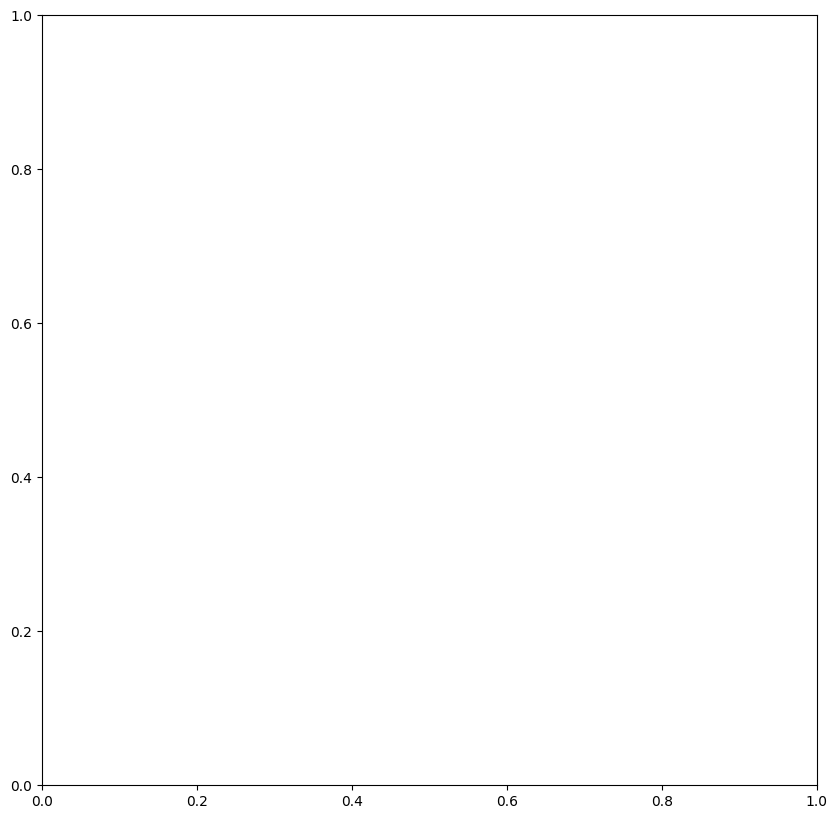

In [10]:
savePath = f"../data/results/graph_{random.randint(1, 9999)}.svg"

try:
    graph.save_graph_svg(savePath)
    print(f"Graphe enregistré avec succès au format SVG : {savePath}")
except Exception as e:
    print(f"Erreur lors de l'enregistrement du graphe en SVG : {e}")